# Lab 4.1 – Skin cancer segmentaion: UNet (MONAI)

This notebook aims to segment skin cancer. **HAM10000 Dataset** (https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification?select=masks) and **UNet** from MONAI library (https://monai-dev.readthedocs.io/en/fixes-sphinx/_modules/monai/networks/nets/unet.html#UNet) are employed for the trial.

This example code will consist of:

0. **Setup**
1. **Load Data & Set Transforms**
2. **Define Model & Set Hyper Parameter**
3. **Train Model**
4. **Inference  & Evaluate**


## 0) Setup
The code below download dataset, imports all required libraries and defines utility functions that will be used in the rest of this notebook.

In [ ]:
# Download Dataset
!wget https://github.com/pvateekul/digitalhealth-ai2025/raw/main/dataset/Ham10000_segment.zip
!unzip -q -o 'Ham10000_segment.zip'

--2025-12-25 09:36:41--  https://github.com/pvateekul/digitalhealth-ai2025/raw/main/dataset/Ham10000_segment.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/dataset/Ham10000_segment.zip [following]
--2025-12-25 09:36:42--  https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/dataset/Ham10000_segment.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55191004 (53M) [application/zip]
Saving to: ‘Ham10000_segment.zip’

Ham10000_segment.zi 100%[===================>]  52.63M  58.0MB/s    in 0.9s    

2025-12-25 09:36:43

In [ ]:
# Pip libraries
!pip install monai
!pip install pytorch-ignite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 13.4 MB/s eta 0:00:00


In [ ]:
import os
import matplotlib.pyplot as plt

import monai
from monai.data import Dataset, CacheDataset, DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    AsDiscrete,
    Compose,
    LoadImaged,
    RandFlipd,
    Resized,
    ScaleIntensityRanged,
)
from monai.utils import first, set_determinism
import numpy as np
from tqdm import tqdm
import glob
import torch
import warnings
warnings.filterwarnings('ignore')

##1) Load Data & Set Transforms


In [ ]:
# Dataset
train_images = sorted(glob.glob(os.path.join("/content/images", "*.jpg")))
train_labels = sorted(glob.glob(os.path.join("/content/masks", "*.png")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files, test_files = data_dicts[:120], data_dicts[120:160], data_dicts[160:]

In [ ]:
# Transforms (pre&post proceeding)
roi_size = (128, 128)
train_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"],ensure_channel_first=True,image_only=True,dtype=torch.float),
            ScaleIntensityRanged(keys=["image", "label"], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
            Resized(keys=["image", "label"], spatial_size=roi_size, mode=["bilinear", "nearest-exact"]),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        ]
    )
val_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"],ensure_channel_first=True,image_only=True,dtype=torch.float),
            ScaleIntensityRanged(keys=["image", "label"], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
            Resized(keys=["image", "label"], spatial_size=roi_size, mode=["bilinear", "nearest-exact"]),
        ]
    )

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

In [ ]:
# DataLoader
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=20)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=20)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=20)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=20)

Loading dataset: 100%|██████████| 40/40 [00:00<00:00, 47.76it/s]


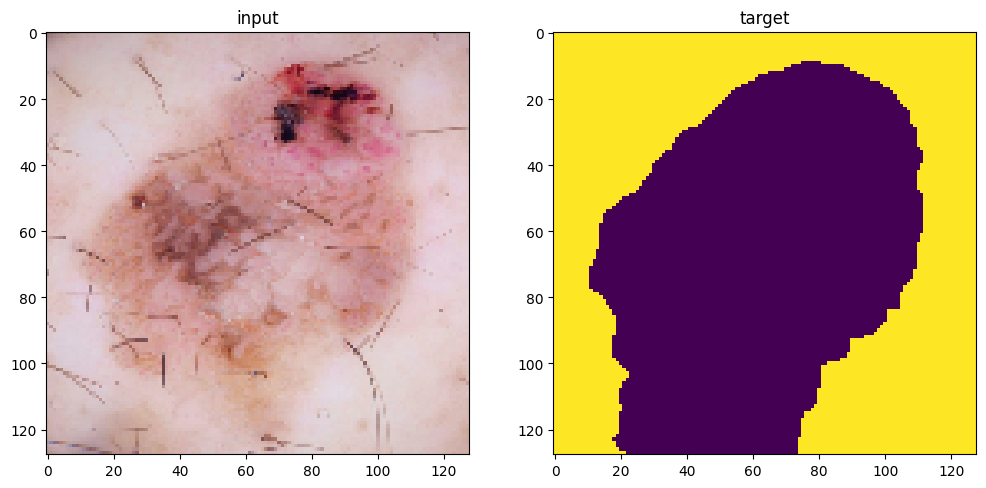

In [ ]:
# Example
check_all_ds = Dataset(data=val_files, transform=val_transforms)
check_all_loader = DataLoader(check_all_ds, batch_size=1)

check_data = first(check_all_loader)
image, label = (check_data["image"][0], check_data["label"][0])
image = image.permute(1, 2, 0).cpu().numpy()

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(image[:, :])
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(label[0][:, :])
plt.show()

## 2) Define Model & Set Hyper Parameter



In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = UNet(spatial_dims=2, in_channels=3, out_channels=2,
             channels=(16, 32, 64, 128), strides=(2, 2, 2)).to(device)

learning_rate = 0.0001 # @param {type:"slider", min:1e-4, max:1e-3, step:1e-4}
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
dice_metric = DiceMetric(include_background=False, reduction="mean")

max_epochs = 20  # @param {type:"slider", min:5, max:50, step:1}
val_interval = 2 # @param {type:"slider", min:1, max:10, step:1}

## 3) Train Model

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()

    epoch_loss = 0
    step = 0
    for i, batch_data in enumerate(train_loader):
        step += 1
        inputs, labels = (batch_data["image"].to(device), batch_data["label"].to(device))

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        if step % 10 == 0:
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                sw_batch_size = 1
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join("UNet_best_metric_model.pth"), _use_new_zipfile_serialization=False) #####
                print("saved new best metric model")
            print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), os.path.join(f"UNet_{epoch + 1}_metric_model.pth"), _use_new_zipfile_serialization=False)
        np.save(os.path.join("UNet_epoch_loss"), np.array(epoch_loss_values))                                                    #####
        np.save(os.path.join("UNet_metric_values"), np.array(metric_values))

----------
epoch 1/20
10/30, train_loss: 1.2236
20/30, train_loss: 1.0010
30/30, train_loss: 0.9455
epoch 1 average loss: 1.1383
----------
epoch 2/20
10/30, train_loss: 1.2474
20/30, train_loss: 0.8114
30/30, train_loss: 1.5433
epoch 2 average loss: 0.9852
saved new best metric model
current epoch: 2 current mean dice: 0.8555
best mean dice: 0.8555 at epoch: 2
----------
epoch 3/20
10/30, train_loss: 0.8340
20/30, train_loss: 0.7994
30/30, train_loss: 0.6812
epoch 3 average loss: 0.9246
----------
epoch 4/20
10/30, train_loss: 0.7468
20/30, train_loss: 1.4453
30/30, train_loss: 0.8831
epoch 4 average loss: 0.8890
saved new best metric model
current epoch: 4 current mean dice: 0.8727
best mean dice: 0.8727 at epoch: 4
----------
epoch 5/20
10/30, train_loss: 0.7571
20/30, train_loss: 0.6652
30/30, train_loss: 1.0981
epoch 5 average loss: 0.8622
----------
epoch 6/20
10/30, train_loss: 0.9662
20/30, train_loss: 1.1380
30/30, train_loss: 1.5439
epoch 6 average loss: 0.8437
saved new best

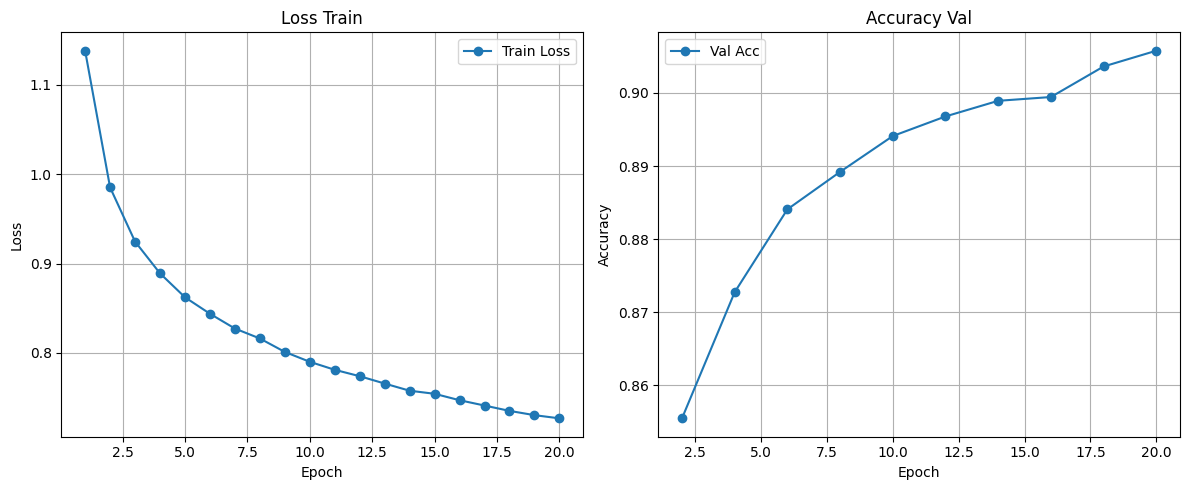

In [ ]:
# Plot grape
n_loss = range(1, len(epoch_loss_values) + 1)
n_acc = range(val_interval, val_interval * len(metric_values) + 1, val_interval)
plt.figure(figsize=(12, 5))

# 🔹 Loss
plt.subplot(1, 2, 1)
plt.plot(n_loss, epoch_loss_values, marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Train')
plt.legend()
plt.grid(True)

# 🔹 Accuracy
plt.subplot(1, 2, 2)
plt.plot(n_acc, metric_values, marker='o', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Val')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 4) Inference  & Evaluate

In [ ]:
def visualize_rgb_with_dice(image, gt, pred, dice_value):
    """
    image: [3, H, W]
    gt:    [1, H, W]
    pred:  [1, H, W]
    dice_value: float
    """
    image = image.permute(1, 2, 0).cpu().numpy()
    gt = gt.squeeze().cpu().numpy()
    pred = pred.squeeze().cpu().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title("Input (RGB)")

    axes[1].imshow(image)
    axes[1].imshow(gt, alpha=0.4, cmap="Greens")
    axes[1].set_title("GT Overlay")

    axes[2].imshow(image)
    axes[2].imshow(pred, alpha=0.4, cmap="Reds")
    axes[2].set_title(f"Prediction\nDice = {dice_value:.4f}")

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
test_ds = CacheDataset(data=test_files, transform=val_transforms, cache_rate=1.0, num_workers=20)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=20)

Loading dataset: 100%|██████████| 40/40 [00:01<00:00, 27.27it/s]


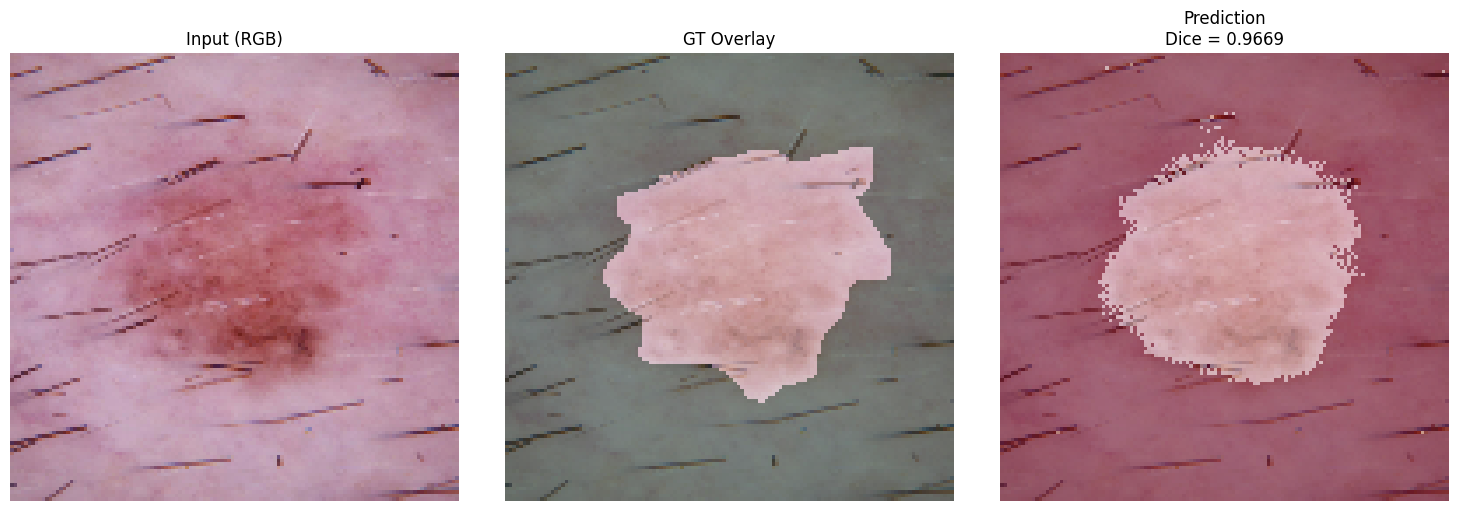

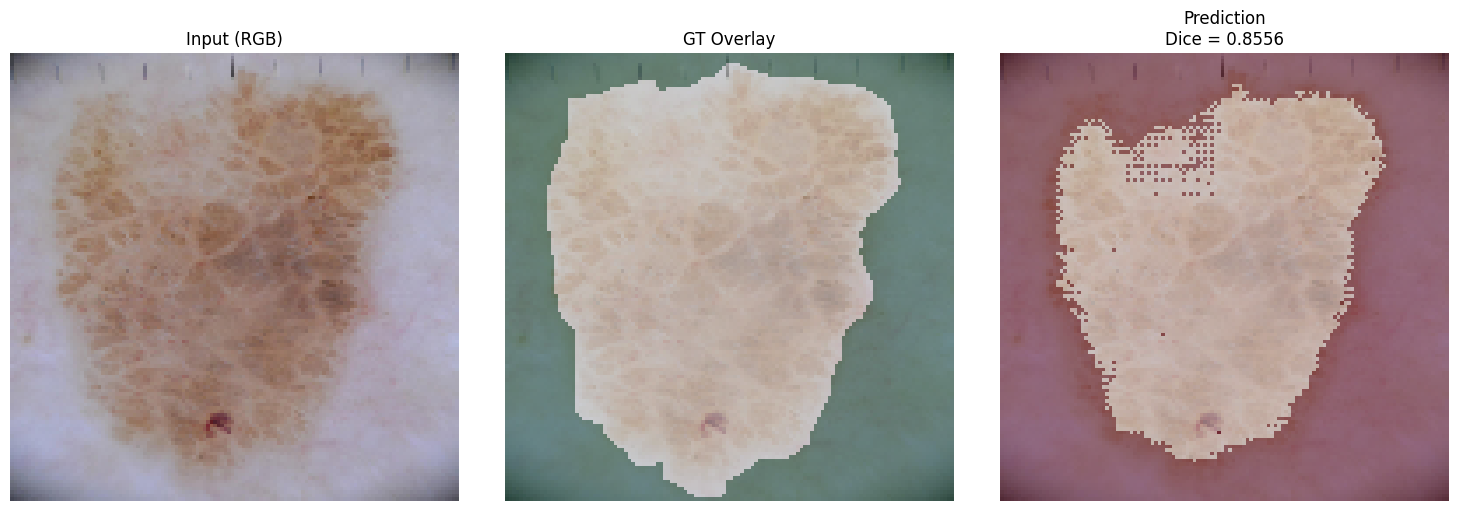

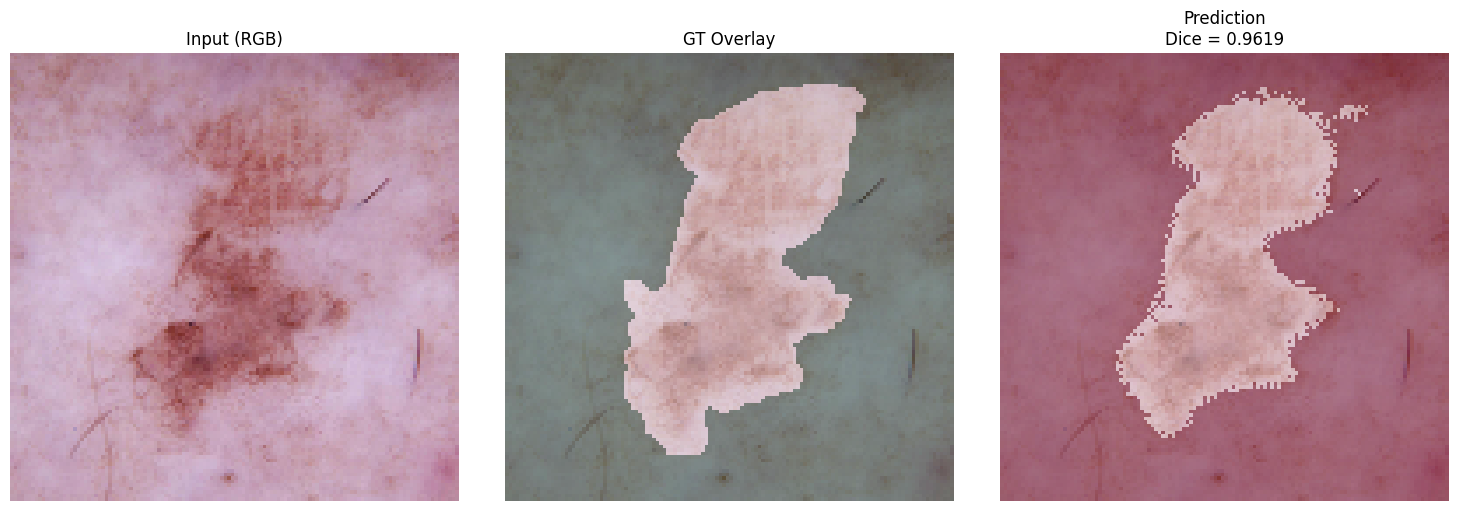

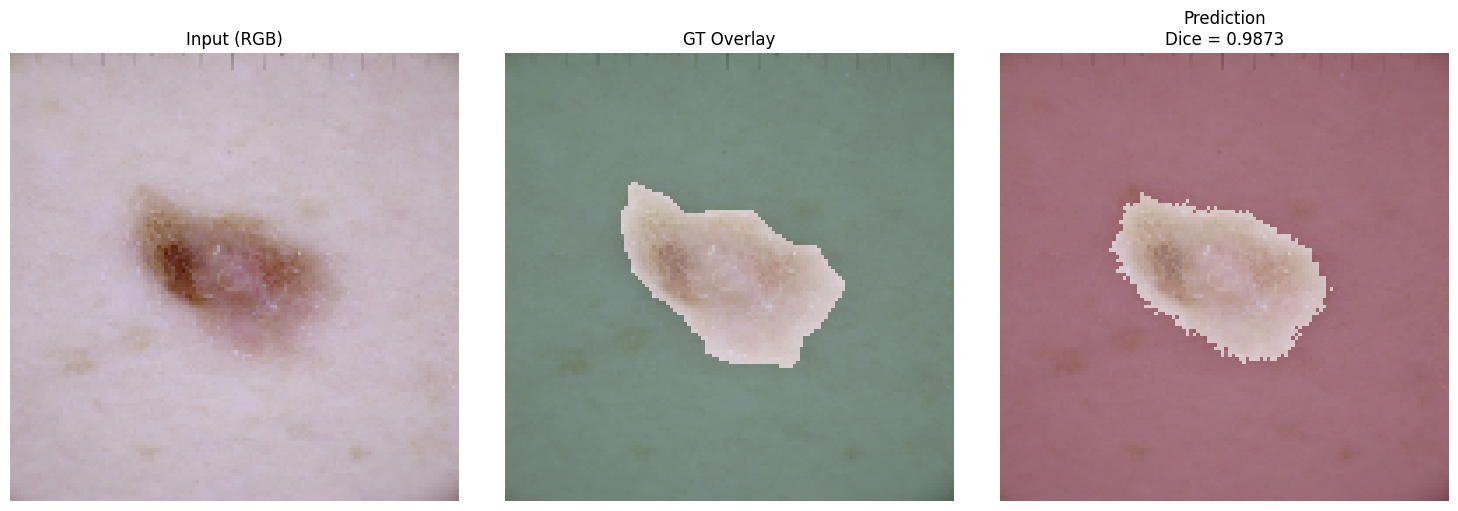

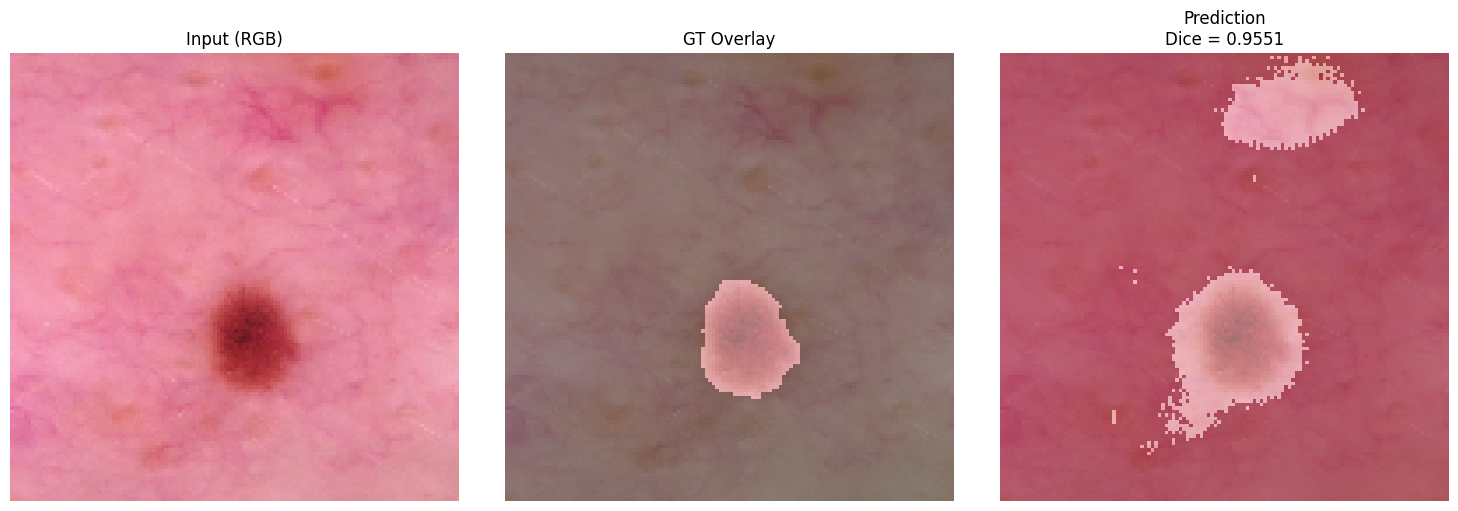

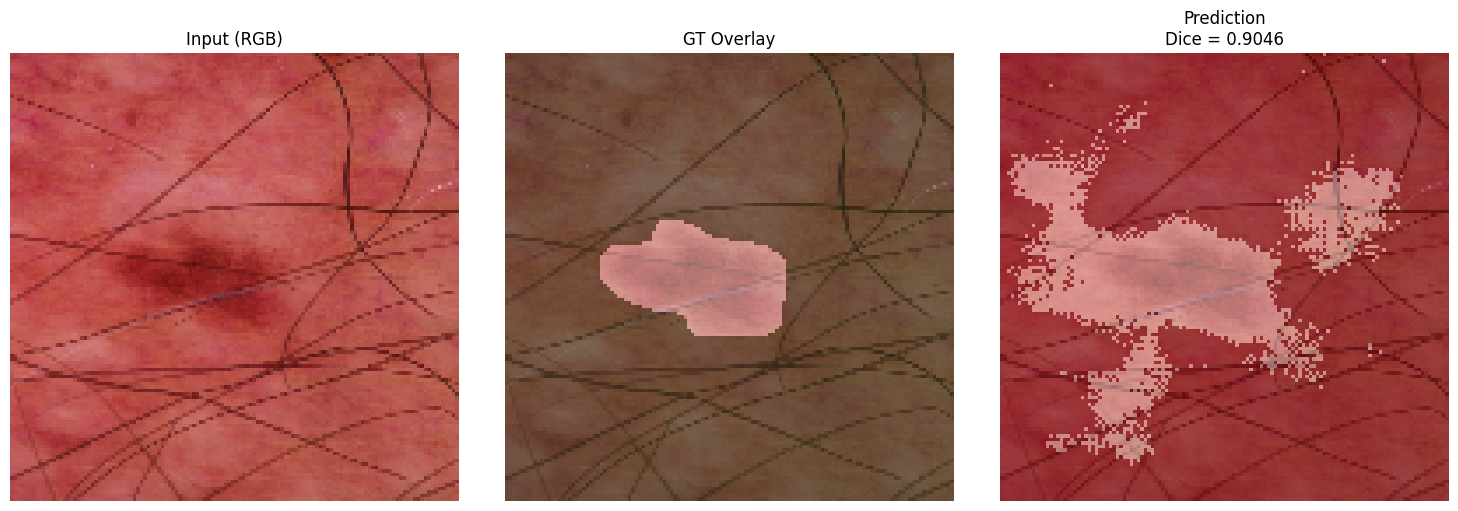

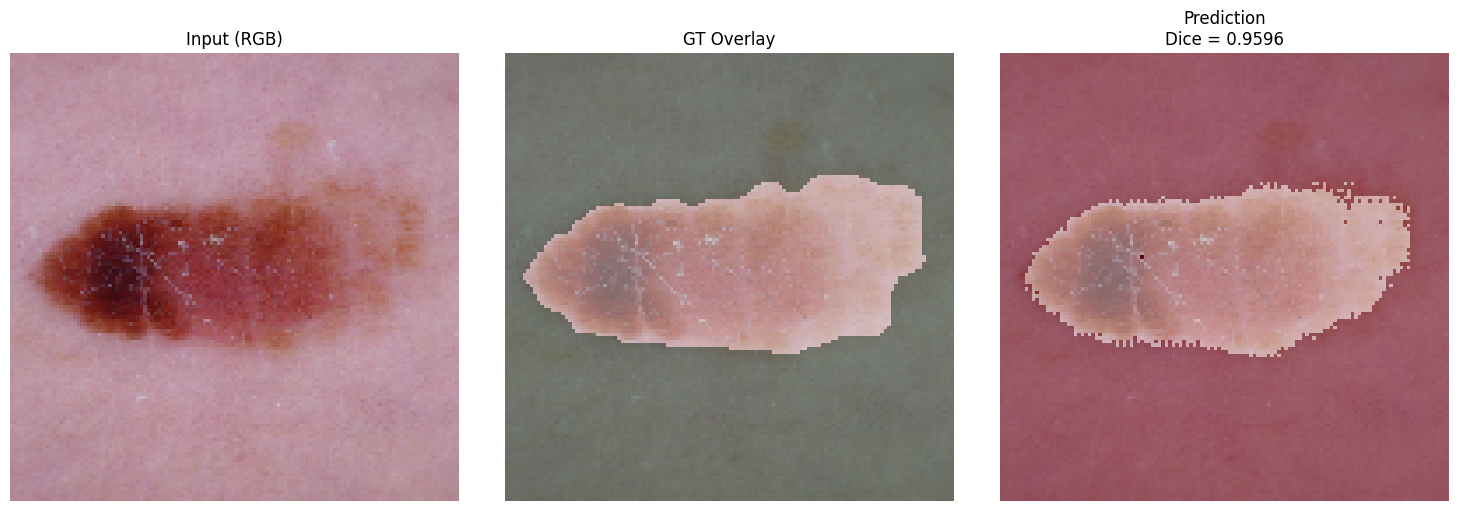

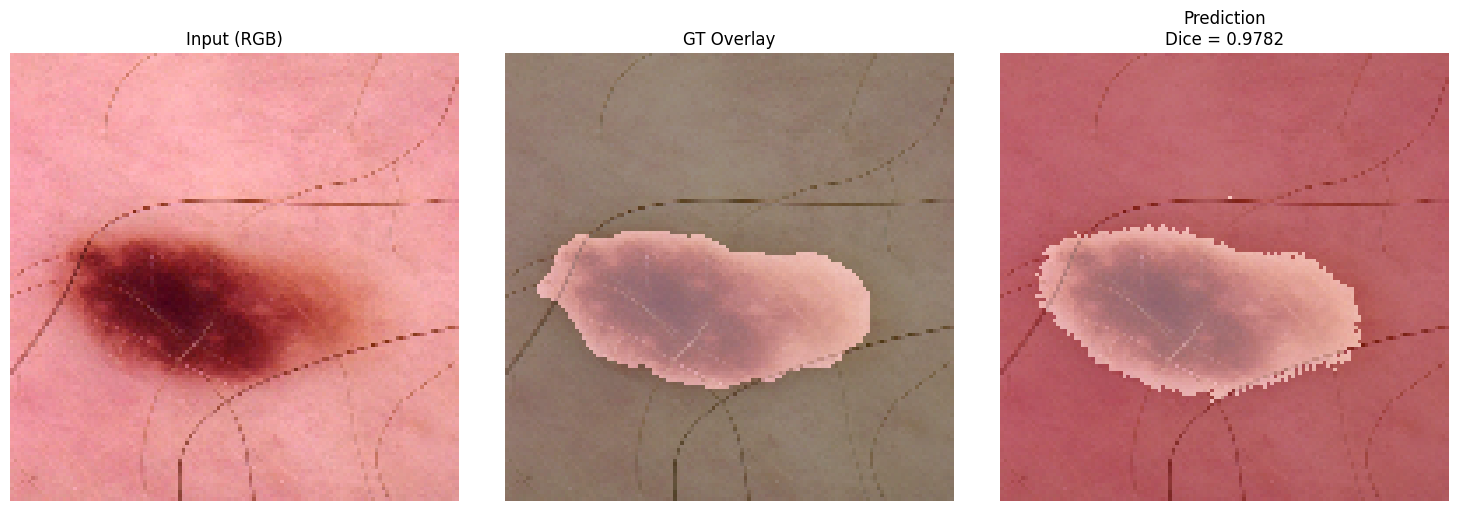


Mean Dice: 0.8925


In [ ]:
model.load_state_dict(torch.load(os.path.join("/content/UNet_best_metric_model.pth")))
model.eval()

DSC_all = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        img = batch["image"].to(device)
        label = batch["label"].to(device)

        logits = model(img)
        pred = torch.argmax(logits, dim=1, keepdim=True)

        dice_metric = DiceMetric(include_background=False, reduction="mean")

        dice_metric(y_pred=pred[0], y=label[0].to(device))
        DSC_all.append(dice_metric.aggregate().item())

        if i % 5 == 0:
            visualize_rgb_with_dice(
                image=img[0],
                gt=label[0],
                pred=pred[0],
                dice_value=dice_metric.aggregate().item()
            )
        dice_metric.reset()



print(f"\nMean Dice: {np.mean(DSC_all):.4f}")